#To show all the codes used are open source


There are four types of codes used in the project, let us start with the track dominance code

After installing fastf1, anyone can use the above code to create their own track dominance map

core           INFO 	Loading data for Spanish Grand Prix - Qualifying [v3.3.9]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['77', '44', '5', '33', '16', '10', '8', '20', '26', '3', '4', '23', '55', '7', '11', '27', '18', '99', '63', '88']
core        WARNING 	Failed to preserve data type for column 'X' while merging telemetry.
core        WARNING 

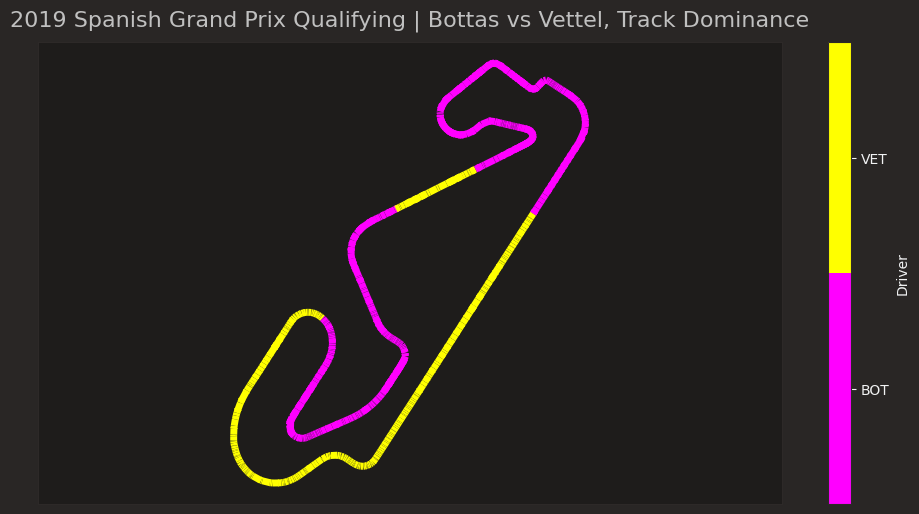

In [5]:
!pip install fastf1 seaborn plotly

import fastf1 as ff1
from fastf1 import plotting
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib import cm
import numpy as np
import pandas as pd
import seaborn as sns

plotting.setup_mpl()

driver01, driver02 = 'BOT', 'VET'
session_event = ff1.get_session(2019, 5, 'Q')
session_event.load()

drivers = [driver01, driver02]
compare_drivers = session_event.laps[session_event.laps['Driver'].isin(drivers)]

fastest_lap_driver01 = session_event.laps.pick_driver(driver01).pick_fastest()
fastest_lap_driver02 = session_event.laps.pick_driver(driver02).pick_fastest()

telemetry_driver01 = fastest_lap_driver01.get_telemetry().add_distance()
telemetry_driver02 = fastest_lap_driver02.get_telemetry().add_distance()

telemetry_driver01['Driver'] = driver01
telemetry_driver02['Driver'] = driver02

telemetry_drivers = pd.concat([pd.DataFrame(telemetry_driver01), pd.DataFrame(telemetry_driver02)], ignore_index=True)

num_minisectors = 7 * 3
minisector_length = max(telemetry_drivers['Distance']) / num_minisectors

telemetry_drivers['Minisector'] = telemetry_drivers['Distance'].apply(lambda dist: int((dist // minisector_length) + 1))

average_speed = telemetry_drivers.groupby(['Minisector', 'Driver'])['Speed'].mean().reset_index()
fastest_driver = average_speed.loc[average_speed.groupby(['Minisector'])['Speed'].idxmax()][['Minisector', 'Driver']].rename(columns={'Driver': 'Fastest_driver'})

telemetry_drivers = telemetry_drivers.merge(fastest_driver, on=['Minisector']).sort_values(by=['Distance'])
telemetry_drivers['Fastest_driver_int'] = telemetry_drivers['Fastest_driver'].map({driver01: 1, driver02: 2})

x, y = np.array(telemetry_drivers['X'].values), np.array(telemetry_drivers['Y'].values)
segments = np.concatenate([np.array([x, y]).T.reshape(-1, 1, 2)[:-1], np.array([x, y]).T.reshape(-1, 1, 2)[1:]], axis=1)

cmap = plt.get_cmap('spring', 2)
lc_comp = LineCollection(segments, norm=plt.Normalize(1, cmap.N+1), cmap=cmap)
lc_comp.set_array(telemetry_drivers['Fastest_driver_int'].to_numpy().astype(float))
lc_comp.set_linewidth(5)

plt.rcParams['figure.figsize'] = [12, 6]
plt.gca().add_collection(lc_comp)
plt.axis('equal')
plt.tick_params(labelleft=False, left=False, labelbottom=False, bottom=False)

cbar = plt.colorbar(mappable=lc_comp, label='Driver', boundaries=np.arange(1, 4))
cbar.set_ticks(np.arange(1.5, 3.5))
cbar.set_ticklabels([driver01, driver02])

plt.title("2019 Spanish Grand Prix Qualifying | Bottas vs Vettel, Track Dominance", color='silver', fontsize=16)
plt.show()


The second code is for the violin graphs to compare laptimes of drivers in race to compare race pace:


core           INFO 	Loading data for Spanish Grand Prix - Race [v3.3.9]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['44', '77', '33', '5', '16', '10', '20', '55', '26', '8', '23', '3', '27', '7', '11', '99', '63', '88', '18', '4']


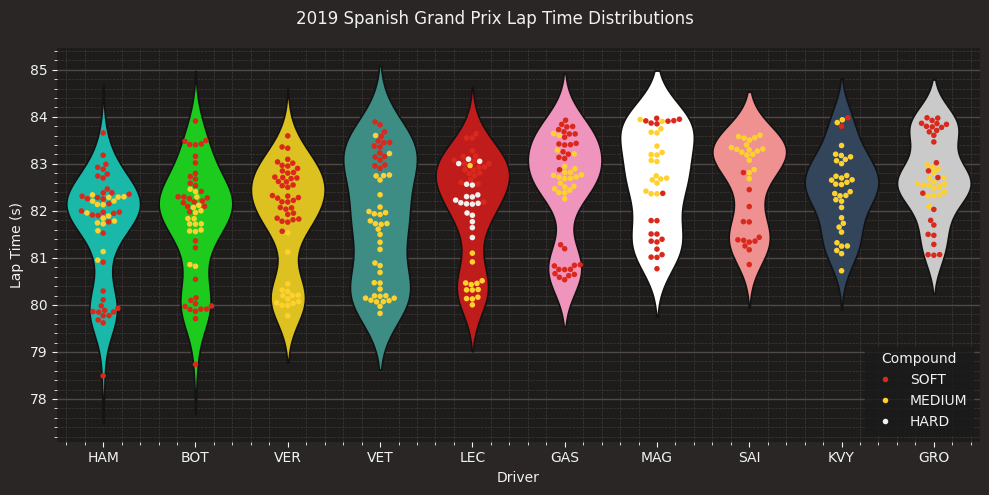

In [6]:
race = ff1.get_session(2019, 5, 'R')
race.load()

driver_laps = race.laps.pick_drivers(race.drivers[:10]).pick_quicklaps().reset_index()

finishing_order = [race.get_driver(i)["Abbreviation"] for i in race.drivers[:10]]
driver_colors = {abv: plotting.DRIVER_COLORS[driver] for abv, driver in plotting.DRIVER_TRANSLATE.items()}
driver_colors.update({"VET": "#2f9b90", "GIO": "#008d01", "MSC": "#9c0000", "LAT": "#012564", "RAI": "#1b3d97", "KVY": "#2b4562", "GRO": "#cacaca"})

driver_laps["LapTime(s)"] = driver_laps["LapTime"].dt.total_seconds()

fig, ax = plt.subplots(figsize=(10, 5))

sns.violinplot(data=driver_laps, x="Driver", y="LapTime(s)", hue="Driver", inner=None, density_norm="area", order=finishing_order, palette=driver_colors)
sns.swarmplot(data=driver_laps, x="Driver", y="LapTime(s)", order=finishing_order, hue="Compound", palette=plotting.COMPOUND_COLORS, hue_order=["SOFT", "MEDIUM", "HARD"], linewidth=0, size=4)

ax.set_xlabel("Driver")
ax.set_ylabel("Lap Time (s)")

plt.suptitle("2019 Spanish Grand Prix Lap Time Distributions")
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()


The last type of code used is the graph to compare between two seperate years of performance at the same track

core           INFO 	Loading data for Belgian Grand Prix - Qualifying [v3.3.9]
req            INFO 	No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for _extended_timing_data. Loading data...
_api           INFO 	Fetching timing data...
_api           INFO 	Parsing timing data...
req            INFO 

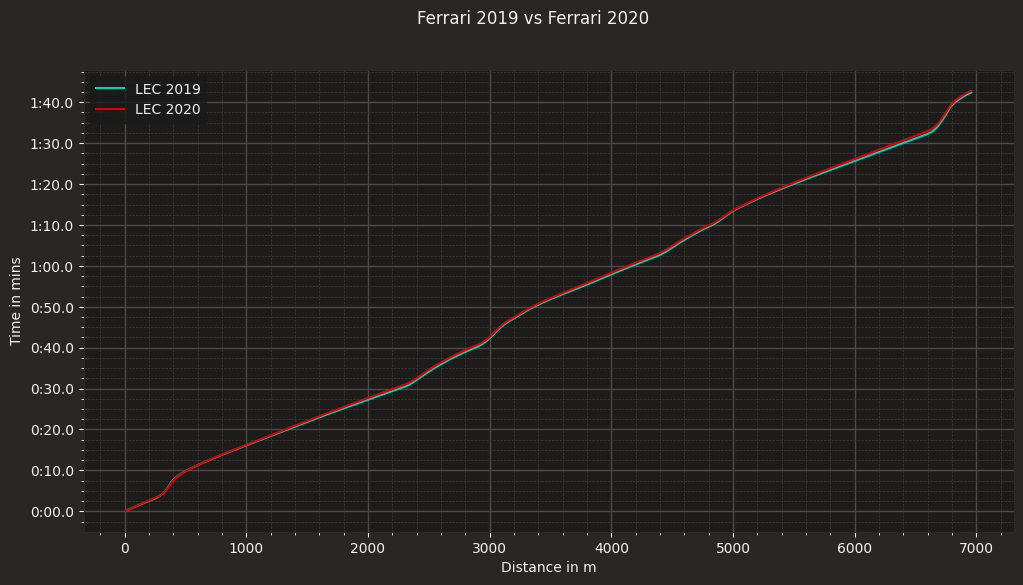

In [7]:
plotting.setup_mpl(misc_mpl_mods=False)

session = ff1.get_session(2019, 13, 'Q')
session.load()
lec_tel1 = session.laps.pick_driver('LEC').pick_fastest().get_car_data().add_distance()

session2 = ff1.get_session(2020, 7, 'Q')
session2.load()
lec_tel2 = session2.laps.pick_driver('LEC').pick_fastest().get_car_data().add_distance()

fig, ax = plt.subplots()
ax.plot(lec_tel1['Distance'], lec_tel1['Time'], color=plotting.team_color('MER'), label='LEC 2019')
ax.plot(lec_tel2['Distance'], lec_tel2['Time'], color=plotting.team_color('FER'), label='LEC 2020')

ax.set_xlabel('Distance in m')
ax.set_ylabel('Time in mins')

ax.legend()
plt.suptitle("Ferrari 2019 vs Ferrari 2020")
plt.show()


All three codes are easily accessible to everyone after downloading the fastf1 package, F1 enthusiasts can use this exact code to create their own graphs and comparisions over any race they want by just tweaking the session details.